# Analyse des parkings de Montpellier
Ce notebook contient le traitement de données effectué dans le cadre de l'analyse de l'usage des parkings de Montpellier.
## Collecte des données
La collecte des données est effectuées toutes les 5 minutes depuis les datasets en Open Data suivants:
- X
- Y

Chaque échantillon est sauvegardée dans son propre dossier timestampé (format ISO 8601/RFC3339, avec une substitution du caractère ':' par '_'), eux mêmes situés selon leur type dans le dossier ``data/{bicycle, car}Parks``.

Pour plus de détails sur la collecte, voir le [code source du collecteur](../main.py)
## Importation
Le script [importerPython](./importerPython.py) est chargé de la déserialization des données récollectées:

In [1]:
import importerPython
import os

# Les scripts doivent tourner depuis la racine du projet.
# Le changement de CWD persistant après l'exécution du snippet, il peut être nécecssaire de décomenter cette ligne, d'exécuter ce snippet, puis de le recommenter.
# Cette situation est hélas assez peu idéale.
#os.chdir("../../") 
#print(os.listdir("."))

carData = importerPython.car()
bicycleData = importerPython.bicycle()


print(f"Total car parkings datapoints: {len(carData)}")
print(f"Total bicycle parkings datapoints: {len(bicycleData)}")

# On stocke ces variables dans le contexte global de notre notebook afin de ne pas avoir à retraiter les données à chaque étape.
%store rawCarData
%store rawBicycleData 

ValueError: invalid literal for int() with base 10: ''

## Filtrage
Certaines données récollectées possèdent un certain nombres d'abérations ou de propriétés les rendant inexploitables:

### Voitures
- Les parkings fermés ne sont pas représentatifs des patterns d'occupations des parkings ouverts et doivent donc être exclus ; 
- Certains parkings ne sont pas marqués comme fermés malgré l'ancienneté des données remontées (Comédie par exemple) ;
- Pour des raisons diverses (réseau, renommage), certains échantillons sont vides ou invalides. Ils doivent donc également être exclus.

On applique donc un certains nombre de filtres:
- Si le statut n'est pas "OPEN", on exclue l'échatillon du dataset
- Si la date de dernière actualisation remontée par l'API diverge de plus de 12 heures de la date de collecte, on exclue l'échantillion du dataset.
- Enfin, si l'échantillon n'est pas un fichier XML valide, on l'exclue également du dataset.

### Vélos
- La capacité totale de certains parkings est égale à 0, ce qui est problématique lors du calcul de la saturation (cas du parking "Bois vert").

Enfin, tous les samples sont triés par ordre chronologique.

Ces filtres sont pour certains appliqués directement à la déserialization, les autres le sont dans le snippet suivant:

In [ ]:
# On charge le dataset
%store -r rawCarData
%store -r rawBicycleData
initialCarSamplesQty = len(carData)
# Filtre de statut
validStatus = ["OPEN", "FULL"]
for park in carData:
    if park.status.upper() not in validStatus:
        print(f"Invalid status for {park.name}: {park.status}")
        carData.remove(park)

print(f"Filtered car data. Valid samples: {len(carData)} out of {initialCarSamplesQty}")

initialBicycleSamplesQty = len(bicycleData)

for park in bicycleData:
    if park.getTotal() == 0:
        bicycleData.remove(park)
        print(f"Removed {park.name}, as its capacity was 0.")

print(f"Filtered car data. Valid samples: {len(bicycleData)} out of {initialBicycleSamplesQty}")


# On trie ensuite par ordre chronologique
carData.sort(key=lambda data: data.date)
# Même traitement pour les vélos:
bicycleData.sort(key=lambda data: data.date)

# On stocke la version filtrée.
%store carData
%store bicycleData

Filtered car data. Valid samples: 1354 out of 1354
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Removed Vert Bois, as its capacity was 0.
Stored 'carData' (list)
Stored 'bicycleData' (list)


## Visualization

### Saturation moyenne

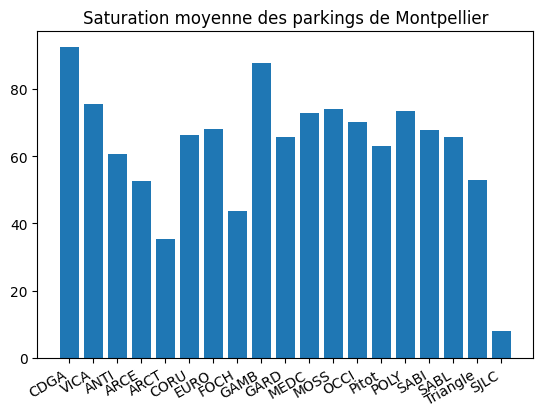

In [ ]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta

# On charge les datasets
%store -r carData
%store -r bicycleData 

# On filtre les parkings
#cutOffDate = int((datetime.today() - timedelta(days=70)).timestamp())
#parkings = [p for p in carData if (p.getDate() > cutOffDate)]

# Format souhaité : {"nom du parking": [ParkingData]}
parkingsByName = {}
for parking in carData:
    previousEntries = parkingsByName.get(parking.name, [])
    previousEntries.append(parking)
    parkingsByName.update({parking.name: previousEntries})

parkingByAvgSaturation = {}

for name, datapoints in parkingsByName.items():
    mean_array = [datapoint.getFree()/(datapoint.getTotal()) for datapoint in datapoints] 
    mean = sum(mean_array)/len(mean_array)*100 # On scale directement en pourcents.
    parkingByAvgSaturation.update({name: mean})

fig, ax = plt.subplots()
#plt.bar(x, y1)
barContainer = plt.bar(parkingByAvgSaturation.keys(), parkingByAvgSaturation.values())
plt.title("Saturation moyenne des parkings de Montpellier")
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas
plt.show()

In [ ]:
from matplotlib import pyplot as plt 
from datetime import datetime, timedelta

# On charge les datasets
%store -r carData
%store -r bicycleData 
parkingsByName = {}
for parking in bicycleData:
    previousEntries = parkingsByName.get(parking.name, [])
    previousEntries.append(parking)
    parkingsByName.update({parking.name: previousEntries})

parkingByAvgSaturation = {}

for name, bicycleParkDataPoints in parkingsByName.items():
    bicycleSaturation = [datapoint.getFree()/datapoint.getTotal() for datapoint in bicycleParkDataPoints if datapoint.getTotal() != 0]  
    mean = sum(mean_array)/len(mean_array)*100 # On scale directement en pourcents.
    parkingByAvgSaturation.update({name: mean})

fig, ax = plt.subplots()
#plt.bar(x, y1)
barContainer = plt.bar(parkingByAvgSaturation.keys(), parkingByAvgSaturation.values())
plt.title("Saturation moyenne des parkings de Montpellier")
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas
plt.show()

no stored variable or alias carData
no stored variable or alias bicycleData


NameError: name 'bicycleData' is not defined

### Corrélation
On calcule la covariance entre le taux de saturation des parkings à voitures et le pourcentage de vélos disponibles dans les parkings à vélos.

On interprétera cette corrélation comme un indicateur de la prévalance de l'effet de "relai vélo", défini comme l'utilisation d'un parking à voiture pour commuter vers un vélo de prêt et inversement.

Bicycle sat len: 0, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat len: 59, car sat len: 69 
Bicycle sat l

TypeError: matshow() missing 1 required positional argument: 'A'

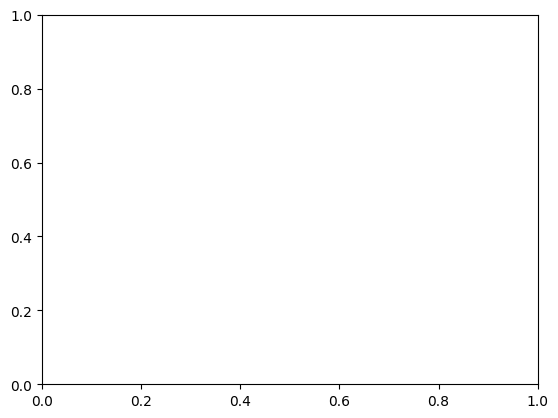

In [ ]:

# On charge les datasets
%store -r carData
%store -r bicycleData 

from numpy import correlate
from Utils import parkingsByName

carParkingsByName = parkingsByName(carData)
bicycleParkingsByName = parkingsByName(bicycleData)

# Forme: {(carParkName, bicycleParkName): int}
correlations = {}

for carParkName, carParkDataPoints in carParkingsByName.items():
    for bicycleParkName, bicycleParkDataPoints in bicycleParkingsByName.items():
        carSaturation = [datapoint.getFree()/datapoint.getTotal() for datapoint in carParkDataPoints] 
        #FIXME: On re-supprime le parking avec une capacité de 0. C'est déjà sensé être filtré mais pour une raison inconnue les données réapparaissent.
        # Même avec ce code ça ne marche pas:
        #[bicycleParkDataPoints.remove(datapoint) for datapoint in bicycleParkDataPoints if datapoint.getTotal()==0]
        # Solution de secours: on utilise un guard: if datapoint.getTotal() != 0
        bicycleSaturation = [datapoint.getFree()/datapoint.getTotal() for datapoint in bicycleParkDataPoints if datapoint.getTotal() != 0] 

        correlations.update({
            (carParkNam e, bicycleParkName): correlate(carParkName, bicycleParkName)
        })

fig, ax = plt.subplots()
print(correlations)
plt.matshow()

plt.title("Corrélation entre chaque parking à vélos et parking à voitures de Montpellier")
fig.autofmt_xdate() # On applique une rotation sur les labels en x afin qu'ils ne se chevauchent pas
plt.show()